### Imports & Helper Function

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import seaborn as sns

sns.set_theme(style='ticks')
sns.set_context('paper')

# from pycaret.regression import *

In [2]:
def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans the input DataFrame by removing columns with more than 50% missing values 
    and rows with any missing values.

    Parameters
    -
    data (pd.DataFrame): The input DataFrame to be cleaned.

    Returns
    -
    pd.DataFrame: The cleaned DataFrame with no missing values.
    
    Prints:
    - The original shape of the DataFrame.
    - The number of missing values in the original DataFrame.
    - The shape of the DataFrame after cleaning.
    """
    print(f'Original Shape: {data.shape}')
    print(f'Number of missing values: {data.isna().sum().sum()}')

    if data.notna().all().all():
        return data

    data = data.dropna(axis=1, thresh=len(data)*.5)
    data = data.dropna()

    print(f'Cleaned Shape: {data.shape}')
    return data

In [3]:
def plot_jointplot(data: pd.DataFrame, x: str, y:str) -> None:
    """
    Plots a jointplot with a regression line between two variables and displays the Pearson correlation coefficient and p-value.

    Parameters
    ----------
    data (DataFrame) : The data containing the variables to be plotted.
    x (str) : The column name of the x variable.
    y (str) : The column name of the y variable.

    Returns
    -------
    None
    """
    r, p = sp.stats.pearsonr(data[x], data[y])

    jgrid = sns.jointplot(data=data, x=x, y=y, kind='reg')
    jgrid.ax_joint.text(
        1, 1, 
        f"r={r:.2f}, p={p:.2e}",
        horizontalalignment='right',
        transform = jgrid.ax_joint.transAxes
    )
    plt.show()

In [4]:
import tpot 
from deap import creator

def tpot_models_dataframe(tpot_model: tpot.base.TPOTBase) -> pd.DataFrame:
    """
    Converts the evaluated individuals from a TPOT model into a DataFrame.

    Parameters
    ----------
    tpot_model (TPOTClassifier or TPOTRegressor) : A fitted TPOT model object.

    Returns
    -------
    pd.DataFrame (DataFrame) : containing the models and their corresponding cross-validation scores,
                  sorted by the cross-validation score in descending order. The DataFrame has two columns:
                  'model' and 'cv_score'.
    """
    scores = {
        model: model_info.get('internal_cv_score')
        for model, model_info in tpot_model.evaluated_individuals_.items()
    }

    scores_df = (
        pd.DataFrame.from_dict(scores, orient='index', columns=['cv_score'])
        .sort_values(by='cv_score', ascending=False)
        .reset_index(names='model')
    )

    return scores_df

def tpot_pipeline_from_string(tpot_model, pipeline_string):
    deap_pipeline = creator.Individual.from_string(pipeline_string, tpot_model._pset)
    sklearn_pipeline = tpot_model._toolbox.compile(expr=deap_pipeline)
    return sklearn_pipeline

c:\ProgramData\miniconda3\envs\mestrado\Lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor

def compare_metric_with_dummy(model, score, X, y, cv):
    """
    Compares the performance of a given model with a dummy regressor using cross-validation.

    Parameters
    ----------
    model (estimator object) : The machine learning model to be evaluated.
    score (str) : The scoring metric to be used for evaluation.
    X (array-like or DataFrame) : The input features for the model.
    y (array-like or Series) : The target variable.
    cv (int or cross-validation generator) : The cross-validation splitting strategy.
    
    Returns
    -
    DataFrame : A DataFrame containing the cross-validation scores for both the dummy regressor and the model, sorted by the model's scores in descending order.
    """
    dummy = DummyRegressor(strategy='mean')

    print("Performing cross-validation for dummy regressor...")
    dummy_scores = cross_val_score(dummy, X, y, cv=cv, scoring=score)

    print("Performing cross-validation for the model...")
    model_scores = cross_val_score(model, X, y, cv=cv, scoring=score)

    return pd.DataFrame({
        'dummy_scores': dummy_scores,
        'model_scores': model_scores
    }).sort_values(by='model_scores', ascending=False)


### Import Data

In [6]:
data = gpd.read_file('../GENERATED-DATA/data_by_zone.geojson')
data.shape

(342, 78)

In [7]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 78 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   NumeroZona                        342 non-null    object  
 1   NomeZona                          342 non-null    object  
 2   NumeroMuni                        342 non-null    object  
 3   NomeMunici                        342 non-null    object  
 4   NumDistrit                        342 non-null    object  
 5   NomeDistri                        342 non-null    object  
 6   Area_ha_2                         342 non-null    float64 
 7   V001_ENTORNO01                    342 non-null    float64 
 8   V002_ENTORNO01                    342 non-null    float64 
 9   V003_ENTORNO01                    342 non-null    float64 
 10  V004_ENTORNO01                    342 non-null    float64 
 11  V001_DOMICILIORENDA               342 non-null    

In [8]:
numeric_data = data.select_dtypes(include=[np.number])
numeric_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 71 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Area_ha_2                         342 non-null    float64
 1   V001_ENTORNO01                    342 non-null    float64
 2   V002_ENTORNO01                    342 non-null    float64
 3   V003_ENTORNO01                    342 non-null    float64
 4   V004_ENTORNO01                    342 non-null    float64
 5   V001_DOMICILIORENDA               342 non-null    float64
 6   V001_BASICO                       342 non-null    float64
 7   V002_BASICO                       342 non-null    float64
 8   V001_DOMICILIO02                  342 non-null    float64
 9   V002_DOMICILIO02                  342 non-null    float64
 10  V001_DOMICILIO01                  342 non-null    float64
 11  V002_DOMICILIO01                  342 non-null    float64
 12  V001_PES

In [9]:
numeric_data = clean_data(numeric_data)

Original Shape: (342, 71)
Number of missing values: 154
Cleaned Shape: (338, 71)


### Plots

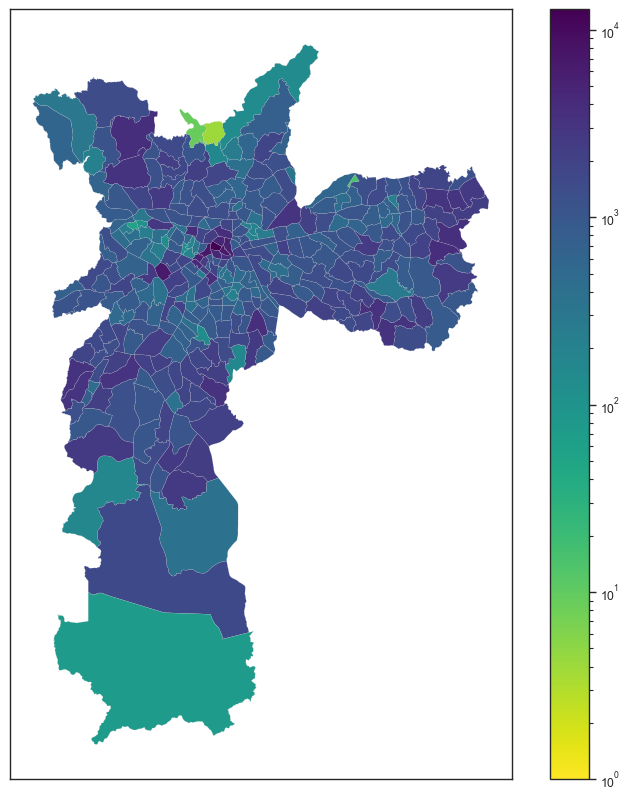

In [10]:
data.plot(
    column='crimes',
    legend=True,
    linewidth=0.1,
    edgecolor='0.8',
    figsize=(10, 10),
    cmap='viridis_r',
    norm=LogNorm(vmin=1, vmax=data['crimes'].max()),
)

plt.xticks([])
plt.yticks([])

plt.show()


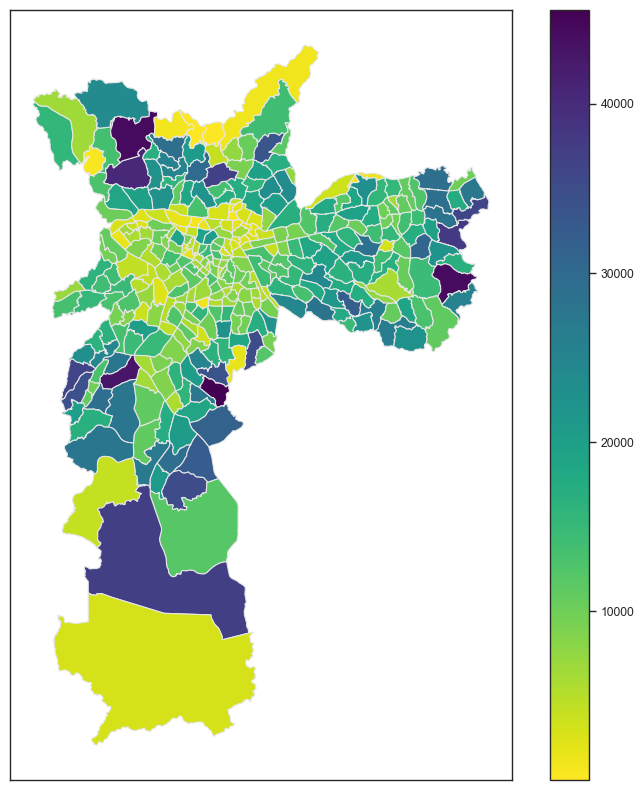

In [11]:
data.plot(
    column='V001_BASICO',
    legend=True,
    linewidth=0.8,
    edgecolor='0.9',
    figsize=(10, 10),
    cmap='viridis_r',
)

plt.xticks([])
plt.yticks([])

plt.show()


### Exploring the connection between crime and other variables

#### CENSUS Variables

In [33]:
df = numeric_data.copy()

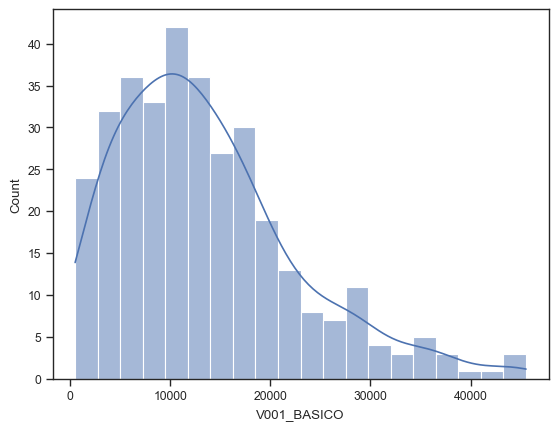

In [34]:
ax = sns.histplot(data=df, x='V001_BASICO', bins=20, kde=True)

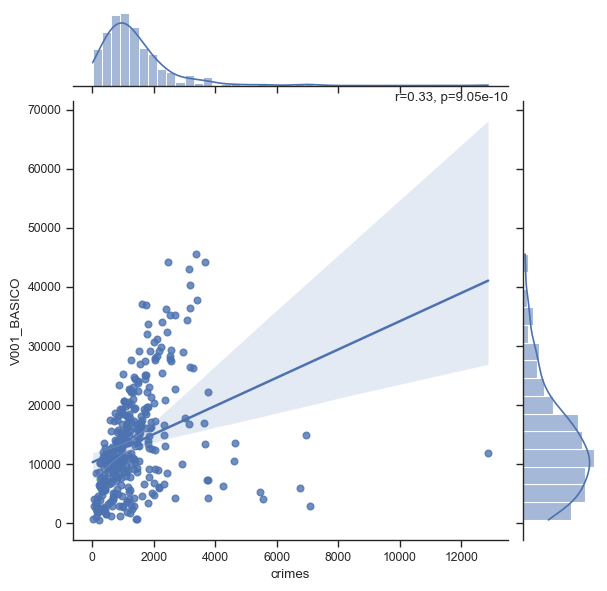

In [37]:
plot_jointplot(df, 'crimes', 'V001_BASICO')

<Axes: xlabel='crimes'>

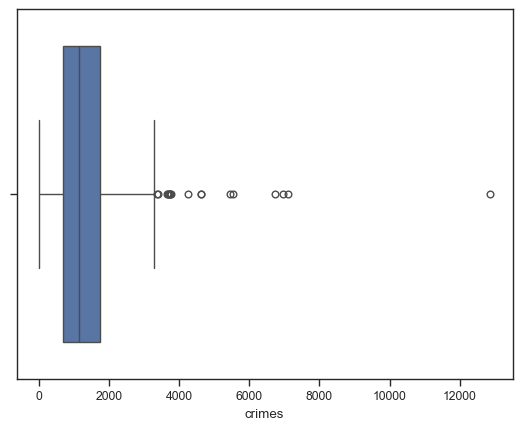

In [38]:
sns.boxplot(data=df, x='crimes')

In [39]:
# remove outliers based on the IQR
Q1 = df['crimes'].quantile(0.25)
Q3 = df['crimes'].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df['crimes'] < (Q1 - 1.5 * IQR)) | (df['crimes'] > (Q3 + 1.5 * IQR)))]

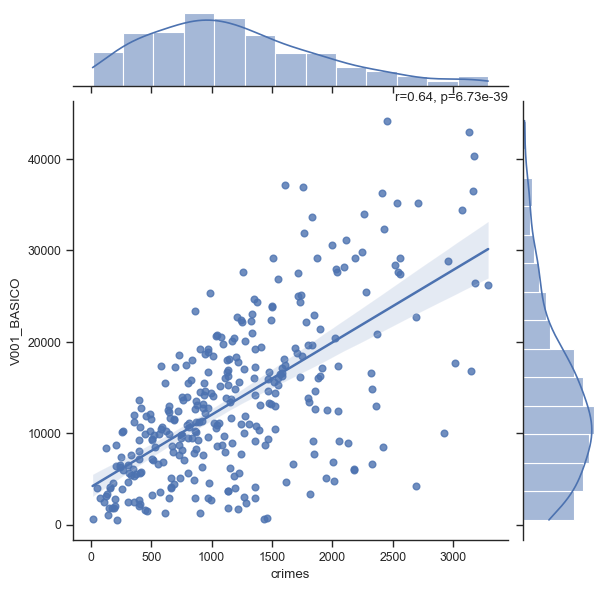

In [40]:
plot_jointplot(df, 'crimes', 'V001_BASICO')

In [18]:
# calcular pearson r for all features
corr_matrix = df.corr().abs()

# show as dataframe
corr_matrix['crimes'].sort_values(ascending=False).to_frame()[:10]

,crimes
crimes,1.000000
V001_DOMICILIO01,0.650906
V001_RESPONSAVEL02,0.650373
V002_DOMICILIO01,0.649702
V001_ENTORNO01,0.649702
V001_BASICO,0.649702
V001_RESPONSAVEL01,0.648125
V086_PESSOA02,0.643211
V001_PESSOA01,0.642189
V001_PESSOA03,0.640371


In [19]:
# it seems to be a lot of multicollinearity with V001_BASICO
# Domicílios particulares permanentes ou pessoas responsáveis por domicílios particulares permanentes

corr_matrix['V001_BASICO'].sort_values(ascending=False).to_frame()[:10]

,V001_BASICO
V001_ENTORNO01,1.000000
V002_DOMICILIO01,1.000000
V001_BASICO,1.000000
V001_RESPONSAVEL02,0.999986
V001_DOMICILIO01,0.999761
V001_PESSOA01,0.994179
V001_PESSOA12,0.992639
V001_RESPONSAVEL01,0.992600
V086_PESSOA02,0.991282
V001_PESSOA03,0.989884


In [20]:
df = df.loc[:, (df.columns == 'V001_BASICO') | (corr_matrix['V001_BASICO'] < 0.8)]

In [21]:
# calcular pearson r for all features
corr_matrix = df.corr().abs()

# show as dataframe
corr_matrix['crimes'].sort_values(ascending=False).to_frame()[:10]

,crimes
crimes,1.000000
V001_BASICO,0.649702
V003_ENTORNO01,0.334308
V005_BASICO,0.276927
V007_BASICO,0.271040
V002_DOMICILIORENDA,0.269395
V003_DOMICILIORENDA,0.269281
V011_BASICO,0.264608
V009_BASICO,0.260154
V006_PESSOA03,0.239055


<Axes: >

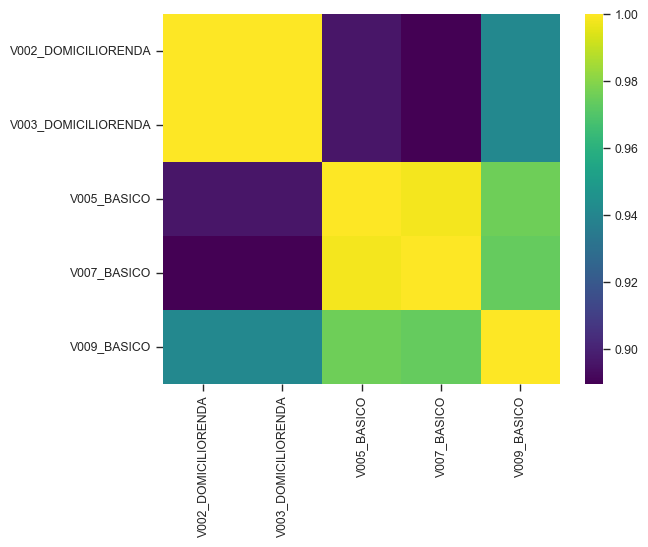

In [22]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

cols = (corr_matrix.mask(mask) > .8).any()
sns.heatmap(corr_matrix.loc[cols, cols], cmap='viridis')

In [23]:
# calcular pearson r for all features
corr_matrix = df.corr().abs()

# show as dataframe
corr_matrix['V005_BASICO'].sort_values(ascending=False).to_frame()[:10]

,V005_BASICO
V005_BASICO,1.000000
V007_BASICO,0.998263
V011_BASICO,0.989076
V009_BASICO,0.975675
V003_DOMICILIORENDA,0.896093
V002_DOMICILIORENDA,0.896049
V003_BASICO,0.612947
V003_ENTORNO01,0.395018
V001_BASICO,0.382838
crimes,0.276927


In [24]:
df = df.loc[:, (df.columns == 'V005_BASICO') | (corr_matrix['V005_BASICO'] < 0.8)]

In [25]:
df.columns

Index(['Area_ha_2', 'V003_ENTORNO01', 'V001_DOMICILIORENDA', 'V001_BASICO',
       'V004_PESSOA03', 'V006_PESSOA03', 'V004_DOMICILIORENDA', 'V003_BASICO',
       'V005_BASICO', 'crimes'],
      dtype='object')

### Regression without Spacial Lag

In [188]:
X = numeric_data.drop(columns='crimes')
y = numeric_data['crimes']

In [189]:
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(
    n_splits=10,
    n_repeats=3,
    random_state=123,
)

#### TPOT

In [10]:
from tpot import TPOTRegressor

tpot_model = TPOTRegressor(
    max_time_mins=60*12,
    verbosity=3,
    random_state=123,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    warm_start=True,
    memory='auto',
    template='Selector-Transformer-Regressor',
)

tpot_model.fit(X, y)

30 operators have been imported by TPOT.
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required by RobustScaler..
_pre_test decorator: _random_mutation_operator: num_test=1 FeatureAgglomeration.__init__() got an unexpected keyword argument 'affinity'.
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required by FastICA..
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False.
_pre_test decorator: _random_mutation_operator: num_test=0 LassoLarsCV.__init__() got an unexpected keyword argument 'normalize'.
_pre_test decorator: _random_mutation_operator: num_test=1 FeatureAgglomeration.__init__() got an unexpected keyword argument 'affi

TPOTRegressor(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=123),
              max_time_mins=720, memory='auto', n_jobs=-1, random_state=123,
              scoring='r2', template='Selector-Transformer-Regressor',
              verbosity=3, warm_start=True)

In [66]:
models = tpot_models_dataframe(tpot_model)
#models.to_csv('..../tpot_models.csv', index=False)
models[:20]

,model,cv_score
0,GradientBoostingRegressor(OneHotEncoder(Varian...,0.572451
1,GradientBoostingRegressor(OneHotEncoder(Varian...,0.572451
2,GradientBoostingRegressor(OneHotEncoder(Varian...,0.572451
3,GradientBoostingRegressor(OneHotEncoder(Varian...,0.572451
4,GradientBoostingRegressor(OneHotEncoder(Varian...,0.572451
5,GradientBoostingRegressor(RobustScaler(Varianc...,0.571964
6,GradientBoostingRegressor(OneHotEncoder(Varian...,0.570530
7,GradientBoostingRegressor(OneHotEncoder(Varian...,0.570530
8,GradientBoostingRegressor(OneHotEncoder(Varian...,0.570530
9,GradientBoostingRegressor(OneHotEncoder(Varian...,0.570530


In [19]:
tpot_model.export('../GENERATED-DATA/tpot_pipeline.py')

In [12]:
top_model = tpot_pipeline_from_string(tpot_model, models.model[0])
top_model

Pipeline(steps=[('variancethreshold', VarianceThreshold(threshold=0.005)),
                ('onehotencoder',
                 OneHotEncoder(minimum_fraction=0.25, sparse=False)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(alpha=0.95, loss='huber',
                                           max_depth=4,
                                           max_features=0.7000000000000001,
                                           min_samples_leaf=4,
                                           min_samples_split=9,
                                           random_state=123,
                                           subsample=0.9000000000000001))])

#### GradientBoosting

In [190]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingRegressor

vt = VarianceThreshold(threshold=0.005)

gdb = GradientBoostingRegressor(
    alpha=0.95, loss='huber', max_depth=4,
    max_features=0.7, min_samples_leaf=4,
    min_samples_split=9, random_state=123,
    subsample=0.9
)

score = 'r2'
df = compare_metric_with_dummy(gdb, score, vt.fit_transform(X), y, cv)
df.abs().describe()

Performing cross-validation for dummy regressor...
Performing cross-validation for the model...


,dummy_scores,model_scores
count,30.000000,30.000000
mean,0.050737,0.556682
std,0.063853,0.134753
min,0.000324,0.160743
25%,0.004559,0.541791
50%,0.024533,0.569075
75%,0.058219,0.642625
max,0.216673,0.741829


#### XGBoost

In [17]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    eval_metric='mae',
    n_estimators=5000,
    learning_rate=0.001,
)

score = 'neg_mean_absolute_error'
df = compare_metric_with_dummy(xgb, score, vt.fit_transform(X), y, cv)
df.abs().describe()

,dummy_scores,model_scores
count,30.000000,30.000000
mean,776.288760,495.814746
std,148.891078,89.994571
min,557.618778,320.103360
25%,672.372341,429.613735
50%,759.831366,500.303425
75%,822.729683,555.453365
max,1171.059211,673.723788


### Regression with Spacial Lag

#### Calculate Spacial Lag

In [26]:
data.crs

<Projected CRS: EPSG:22523>
Name: Corrego Alegre 1970-72 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - onshore between 48°W and 42°W and south of 15°S.
- bounds: (-48.0, -25.29, -42.0, -15.0)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Corrego Alegre 1970-72
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

In [27]:
data = clean_data(data)

Original Shape: (342, 78)
Number of missing values: 154
Cleaned Shape: (338, 78)


In [28]:
from pysal.lib import weights

knn = weights.KNN.from_dataframe(data, k=5) # k=5 -> 50%
#wq  = weights.contiguity.Rook.from_dataframe(data)
#w_kernel = weights.distance.Kernel.from_dataframe(data)

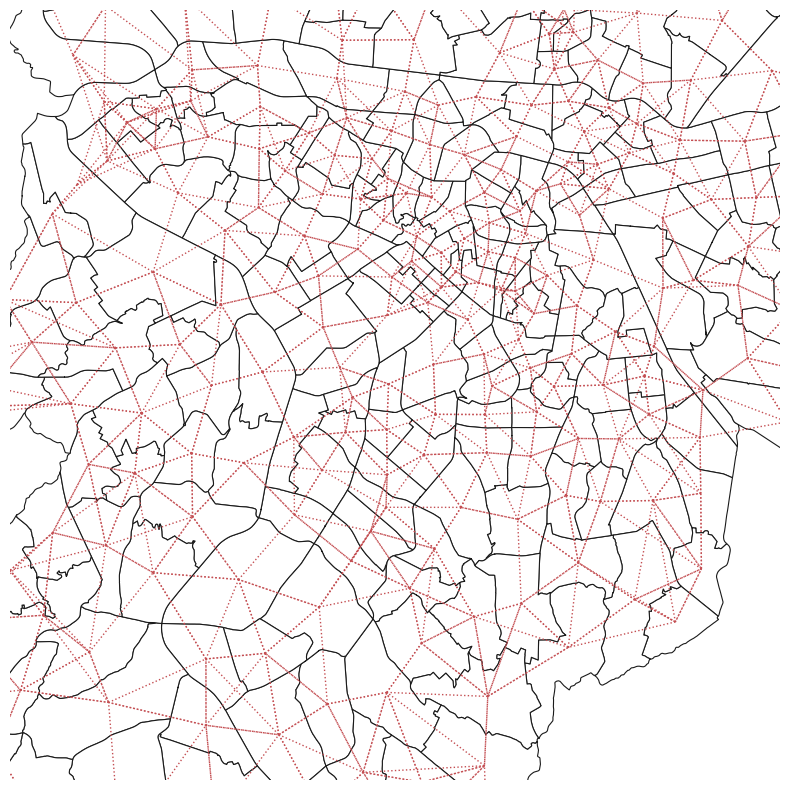

In [29]:
f, axs = plt.subplots(figsize=(10, 10))

# Plot the data with edge color and face color
data.plot(
    edgecolor="k", facecolor="w", ax=axs
)
# Plot the KNN with custom edge and node keywords
knn.plot(
    data,
    ax=axs,
    edge_kws=dict(color="r", linestyle=":", linewidth=1),
    node_kws=dict(marker="")
)
# Set axis limits and turn off the axis
axs.axis([3.2e5, 3.4e5, 7.38e6, 7.4e6])
axs.set_axis_off();

In [30]:
gdf_lag = (
    numeric_data
    .apply(
        lambda y: weights.spatial_lag.lag_spatial(knn, y)
    )
    .rename(
        columns=lambda c: "LAG_" + c
    )
)

In [31]:
gdf_lag.shape

(338, 71)

In [32]:
gdf_lag

,LAG_Area_ha_2,LAG_V001_ENTORNO01,LAG_V002_ENTORNO01,LAG_V003_ENTORNO01,LAG_V004_ENTORNO01,LAG_V001_DOMICILIORENDA,LAG_V001_BASICO,LAG_V002_BASICO,LAG_V001_DOMICILIO02,LAG_V002_DOMICILIO02,...,LAG_motivo_d_Médico/Dentista/Saúde,LAG_motivo_d_Procurar Emprego,LAG_motivo_d_Recreação/Visitas/Lazer,LAG_motivo_d_Refeição,LAG_motivo_d_Residência,LAG_motivo_d_Trabalho Comércio,LAG_motivo_d_Trabalho Indústria,LAG_motivo_d_Trabalho Serviços,LAG_viagens,LAG_crimes
0,394.38,47041.0,22068.0,655.0,21279.0,135.0,47041.0,107466.0,108765.0,107466.0,...,0.082367,0.034200,0.148411,0.357632,1.030954,0.510370,0.061760,1.813181,2816.0,31380.0
1,296.45,26063.0,10938.0,197.0,13073.0,140.0,26063.0,69367.0,70402.0,69367.0,...,0.026629,0.012912,0.068215,0.338840,1.587651,0.800946,0.086932,1.345514,2486.0,17294.0
2,357.10,36141.0,16581.0,702.0,16277.0,50.0,36141.0,82314.0,84572.0,82314.0,...,0.140161,0.025772,0.158730,0.276072,1.129087,0.374087,0.080658,1.445022,2875.0,20223.0
3,274.41,40418.0,19049.0,484.0,18374.0,42.0,40418.0,92495.0,95267.0,92495.0,...,0.126032,0.027129,0.117124,0.367172,1.298579,0.231895,0.085247,1.767895,2764.0,25826.0
4,448.81,62572.0,30229.0,1081.0,27106.0,153.0,62572.0,136393.0,138736.0,136393.0,...,0.119593,0.017575,0.201351,0.356767,1.183216,0.313611,0.053762,1.679028,3047.0,25672.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,855.51,26403.0,18244.0,751.0,5347.0,95.0,26403.0,75201.0,75716.0,75201.0,...,0.022998,0.003534,0.077432,0.129014,1.935901,0.564731,0.120189,1.039150,1439.0,2505.0
338,1200.55,37498.0,25962.0,337.0,7613.0,37.0,37498.0,110609.0,111456.0,110609.0,...,0.082377,0.002278,0.157676,0.103223,2.400889,0.140828,0.105475,0.924932,1837.0,5819.0
339,1553.63,23126.0,16580.0,82.0,4789.0,19.0,23126.0,65778.0,66882.0,65778.0,...,0.082192,0.006866,0.187284,0.162159,1.729979,0.140861,0.079745,1.202023,2718.0,8894.0
340,1731.54,43129.0,30962.0,201.0,9126.0,26.0,43129.0,126329.0,127328.0,126329.0,...,0.105337,0.009741,0.135513,0.086477,1.926384,0.145778,0.110324,0.923254,2289.0,6683.0


In [33]:
data_lag = numeric_data.join(gdf_lag)
data_lag

,Area_ha_2,V001_ENTORNO01,V002_ENTORNO01,V003_ENTORNO01,V004_ENTORNO01,V001_DOMICILIORENDA,V001_BASICO,V002_BASICO,V001_DOMICILIO02,V002_DOMICILIO02,...,LAG_motivo_d_Médico/Dentista/Saúde,LAG_motivo_d_Procurar Emprego,LAG_motivo_d_Recreação/Visitas/Lazer,LAG_motivo_d_Refeição,LAG_motivo_d_Residência,LAG_motivo_d_Trabalho Comércio,LAG_motivo_d_Trabalho Indústria,LAG_motivo_d_Trabalho Serviços,LAG_viagens,LAG_crimes
0,57.10,2879.0,1232.0,16.0,1271.0,0.0,2879.0,7740.0,7796.0,7740.0,...,0.082367,0.034200,0.148411,0.357632,1.030954,0.510370,0.061760,1.813181,2816.0,31380.0
1,113.64,4093.0,1638.0,70.0,2025.0,4.0,4093.0,10861.0,10923.0,10861.0,...,0.026629,0.012912,0.068215,0.338840,1.587651,0.800946,0.086932,1.345514,2486.0,17294.0
2,47.75,7236.0,3273.0,53.0,3417.0,0.0,7236.0,18726.0,18747.0,18726.0,...,0.140161,0.025772,0.158730,0.276072,1.129087,0.374087,0.080658,1.445022,2875.0,20223.0
3,75.11,13502.0,6504.0,370.0,5814.0,5.0,13502.0,27565.0,27852.0,27565.0,...,0.126032,0.027129,0.117124,0.367172,1.298579,0.231895,0.085247,1.767895,2764.0,25826.0
4,74.95,11787.0,5861.0,90.0,5143.0,5.0,11787.0,24173.0,24283.0,24173.0,...,0.119593,0.017575,0.201351,0.356767,1.183216,0.313611,0.053762,1.679028,3047.0,25672.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,430.44,11058.0,4960.0,417.0,1658.0,27.0,11058.0,35234.0,35347.0,35234.0,...,0.022998,0.003534,0.077432,0.129014,1.935901,0.564731,0.120189,1.039150,1439.0,2505.0
338,584.56,4427.0,2784.0,1.0,1007.0,6.0,4427.0,13066.0,13394.0,13066.0,...,0.082377,0.002278,0.157676,0.103223,2.400889,0.140828,0.105475,0.924932,1837.0,5819.0
339,207.11,4214.0,3044.0,9.0,882.0,5.0,4214.0,12101.0,12207.0,12101.0,...,0.082192,0.006866,0.187284,0.162159,1.729979,0.140861,0.079745,1.202023,2718.0,8894.0
340,180.08,5062.0,3736.0,48.0,874.0,3.0,5062.0,14129.0,14301.0,14129.0,...,0.105337,0.009741,0.135513,0.086477,1.926384,0.145778,0.110324,0.923254,2289.0,6683.0


#### Regression

In [36]:
X = data_lag.drop(columns='crimes')
y = data_lag['crimes']

from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(
    n_splits=10,
    n_repeats=3,
    random_state=123,
)

In [37]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingRegressor

vt = VarianceThreshold(threshold=0.005)

gdb = GradientBoostingRegressor(
    alpha=0.95, loss='huber', max_depth=4,
    max_features=0.7, min_samples_leaf=4,
    min_samples_split=9, random_state=123,
    subsample=0.9
)

score = 'r2'
df = compare_metric_with_dummy(gdb, score, vt.fit_transform(X), y, cv)
df.abs().describe()

Performing cross-validation for dummy regressor...
Performing cross-validation for the model...


,dummy_scores,model_scores
count,30.000000,30.000000
mean,0.050737,0.579215
std,0.063853,0.127876
min,0.000324,0.265345
25%,0.004559,0.509003
50%,0.024533,0.595271
75%,0.058219,0.673537
max,0.216673,0.797263


In [38]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    eval_metric='mae',
    n_estimators=5000,
    learning_rate=0.001,
)

score = 'r2'
df = compare_metric_with_dummy(xgb, score, vt.fit_transform(X), y, cv)
df.abs().describe()

Performing cross-validation for dummy regressor...
Performing cross-validation for the model...


,dummy_scores,model_scores
count,30.000000,30.000000
mean,0.050737,0.488021
std,0.063853,0.190968
min,0.000324,0.065049
25%,0.004559,0.388251
50%,0.024533,0.505106
75%,0.058219,0.624297
max,0.216673,0.842419
